# Dynamic Time Warping

Copyright (c) 2021 Herman Kamper, [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/)

## Motivation

![](fig/Two_repetitions_of_a_walking_sequence_of_an_individual_recorded_using_a_motion-capture_system.gif)

Figure source: [link](https://en.wikipedia.org/wiki/File:Two_repetitions_of_a_walking_sequence_of_an_individual_recorded_using_a_motion-capture_system.gif).

## Preliminaries

In [1]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist

## Dynamic programming function

In [4]:
def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def convert_secs_to_idx(
    unknown_time_min, unknown_time_max, reference_pair: dict, hertz: int
):
    reference_time = list(reference_pair.keys())[0]  # has to come from 0
    reference_idx = list(reference_pair.values())[0]

    # first find the time difference between reference and unknown
    # Note: reference will
    idx_start = (unknown_time_min * hertz) + reference_idx
    # idx_end = (unknown_time_max * hertz) + reference_idx + 1
    # ^plus 1 bc getting sublist is exclusive? 11/30/21
    idx_end = (unknown_time_max * hertz) + reference_idx
    return int(idx_start), int(idx_end)
    
def create_subwindow_for_col(
    df, col, unknown_time_min, unknown_time_max, reference_pair, hertz
) -> list:
    idx_start, idx_end = convert_secs_to_idx(
        unknown_time_min, unknown_time_max, reference_pair, hertz
    )
    # print(idx_start, idx_end)
    subwindow = df[col][idx_start:idx_end]
    # print(subwindow)
    return subwindow

def zscore(obs_value, mu, sigma):
    return (obs_value - mu) / sigma

def custom_standardize(
    df, unknown_time_min, unknown_time_max, reference_pair: dict, hertz: int
):
    # print(df.head())
    for col in df.columns:
        subwindow = create_subwindow_for_col(
            df, col, unknown_time_min, unknown_time_max, reference_pair, hertz
        )
        mean_for_cell = stats.tmean(subwindow)
        stdev_for_cell = stats.tstd(subwindow)
        # print(subwindow)
        # print(f"Mean {mean_for_cell} for cell {col}")
        # print(stdev_for_cell)

        new_col_vals = []
        for ele in list(df[col]):
            z_value = zscore(ele, mean_for_cell, stdev_for_cell)
            new_col_vals.append(z_value)

        # print(new_col_vals[0:10])  # has nan values
        df[col] = new_col_vals  # <- not neccesary bc of the .apply function?
    return df

def gaussian_smooth(df, sigma: float = 1.5):
    from scipy.ndimage import gaussian_filter1d

    return df.apply(gaussian_filter1d, sigma=sigma, axis=0)


## Univariate examples

### Example 1

In [28]:
csv_path = "/Users/rodrigosandon/Documents/GitHub/LBGN/SampleData/truncating_bug/RDT D2/Shock Ocurred_Choice Time (s)/True/all_concat_cells.csv"
df_all_cells_rdt2_shock_true = pd.read_csv(csv_path)

#print(df_all_cells_rdt2_shock_true.head())
#print(df_all_cells_rdt2_shock_true.columns)
#print(len(list(df_all_cells_rdt2_shock_true.columns)))

In [29]:
df_all_cells_rdt2_shock_true = custom_standardize(
        df_all_cells_rdt2_shock_true,
        unknown_time_min=-10.0,
        unknown_time_max=-1.0,
        reference_pair={0: 100},
        hertz=10,
    )
    # print("AFTER STANDARDIZATION:")
    # print(df.head())

    # SMOOTHING NEEDS TRANSPOSE BC SMOOTHING RELATIVE TO EACH CELL'S BASELINE (so axis should be 1
    # bc smoothing across columns)
df_all_cells_rdt2_shock_true = gaussian_smooth(df_all_cells_rdt2_shock_true.T)
# THEN TRANSPOSE IT BACK
df_all_cells_rdt2_shock_true = df_all_cells_rdt2_shock_true.T

In [30]:
BLA_Insc_7_C03 = list(df_all_cells_rdt2_shock_true["BLA-Insc-7_C03"])
#print(BLA_Insc_7_C03)
BLA_Insc_7_C04 = list(df_all_cells_rdt2_shock_true["BLA-Insc-7_C04"])

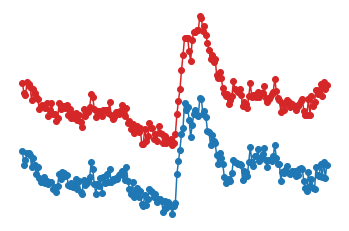

In [31]:
x = np.array(BLA_Insc_7_C03)
y = np.array(BLA_Insc_7_C04)

plt.figure(figsize=(6, 4))
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
plt.savefig("/Users/rodrigosandon/Documents/GitHub/LBGN/SampleData/truncating_bug/RDT D2/Shock Ocurred_Choice Time (s)/True/signals_a_b.png")

In [32]:
# Distance matrix
N = x.shape[0]
M = y.shape[0]
dist_mat = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        dist_mat[i, j] = abs(x[i] - y[j])

Alignment cost: 34.1476
Normalized alignment cost: 0.0854


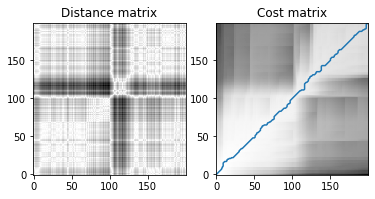

In [33]:
# DTW
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);

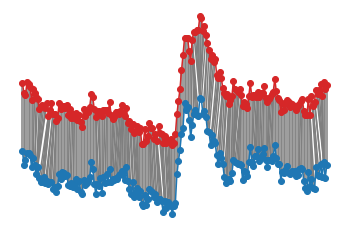

In [34]:
plt.figure()
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
plt.savefig("/Users/rodrigosandon/Documents/GitHub/LBGN/SampleData/truncating_bug/RDT D2/Shock Ocurred_Choice Time (s)/True/signals_a_b_align.png")

Alignment cost: 2.5000
Normalized alignment cost: 0.1042

Alignment cost: 1.7500
Normalized alignment cost: 0.0972

Alignment cost: 0.5000
Normalized alignment cost: 0.0208



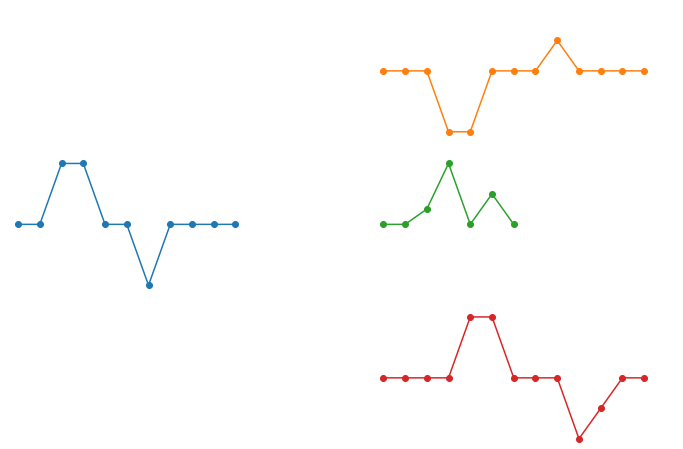

In [7]:
a = np.array([0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0])
b = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -0.5, 0, 0])
c = np.array([0, 0, 0, -1, -1, 0, 0, 0, 0.5, 0, 0, 0, 0])
d = np.array([0, 0, 0.25, 1, 0, 0.5, 0])

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(323)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(324)
ax4 = fig.add_subplot(326)
# fig = plt.figure(figsize=(6, 8))
ax1.plot(np.arange(a.shape[0]), a, "-o", c="C0")
ax2.plot(np.arange(c.shape[0]), c, "-o", c="C1")
ax3.plot(np.arange(d.shape[0]), d, "-o", c="C2")
ax4.plot(np.arange(b.shape[0]), b, "-o", c="C3")
for ax in [ax1, ax2, ax3, ax4]:
    ax.axis("off")
    ax.set_xlim([-0.5, 13.5])
    ax.set_ylim([-1.05, 1.05])
plt.savefig("fig/dtw_knn.pdf")
    
for cur_b in [c, d, b]:

    # Distance matrix
    N = a.shape[0]
    M = cur_b.shape[0]
    dist_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
    #         print(a[i], b[j], abs(a[i] - b[j]))
            dist_mat[i, j] = abs(a[i] - cur_b[j])

    # DTW
    path, cost_mat = dp(dist_mat)
    print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
    print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))
    print()

### Example 2

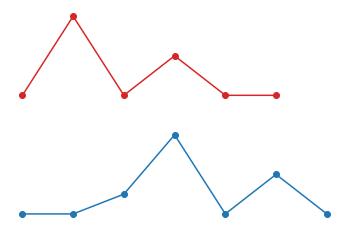

In [8]:
x = np.array([0, 2, 0, 1, 0, 0])
y = np.array([0, 0, 0.5, 2, 0, 1, 0])

plt.figure(figsize=(6, 4))
plt.plot(np.arange(x.shape[0]) + 1, x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]) + 1, y - 1.5, "-o", c="C0")
plt.axis("off")
plt.savefig("fig/signals_a_b_ex2.pdf")

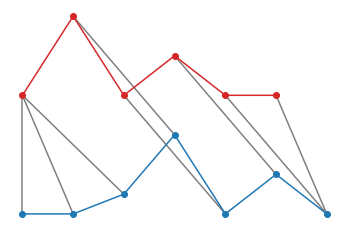

In [9]:
# Distance matrix
N = x.shape[0]
M = y.shape[0]
dist_mat = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        dist_mat[i, j] = abs(x[i] - y[j])

# DTW
path, cost_mat = dp(dist_mat)

# Plot alignment
plt.figure(figsize=(6, 4))
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off");

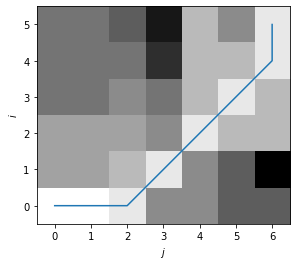

In [10]:
plt.figure(figsize=(6, 4))
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path)
plt.xlabel("$j$")
plt.ylabel("$i$");

### Example 3

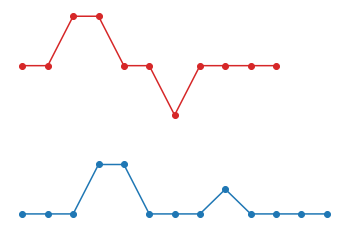

In [11]:
x = np.array([0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0])
y = np.array([0, 0, 0, 1, 1, 0, 0, 0, 0.5, 0, 0, 0, 0])

plt.figure(figsize=(6, 4))
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
plt.savefig("fig/signals_a_b.pdf")

Alignment cost: 1.5000
Normalized alignment cost: 0.0625


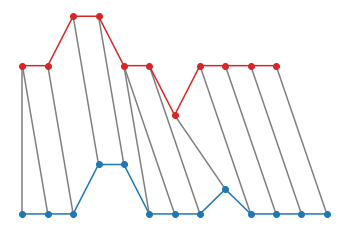

In [12]:
# Distance matrix
N = x.shape[0]
M = y.shape[0]
dist_mat = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        dist_mat[i, j] = abs(x[i] - y[j])

# DTW
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

# Plot alignment
plt.figure(figsize=(6, 4))
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off");

## Multivariate examples

In [13]:
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display

In [14]:
# x_fn = "audio/hello1.wav"
# x_fn = "audio/hello2.wav"
x_fn = "audio/goodbye.wav"
f_s, x = wavfile.read(x_fn)
ipyd.Audio(rate=f_s, data=x)

In [15]:
# y_fn = "audio/hello3.wav"
y_fn = "audio/bye.wav"
f_s, y = wavfile.read(y_fn)
ipyd.Audio(rate=f_s, data=y)

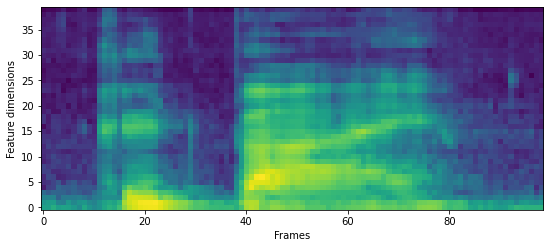

In [16]:
# Mel-scale spectrogram
n_fft = int(0.025*f_s)      # 25 ms
hop_length = int(0.01*f_s)  # 10 ms
mel_spec_x = librosa.feature.melspectrogram(
    x/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
    )
log_mel_spec_x = np.log(mel_spec_x)

# Plot log-Mel spectrogram
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(log_mel_spec_x, origin="lower", interpolation="nearest");
plt.ylabel("Feature dimensions")
plt.xlabel("Frames");

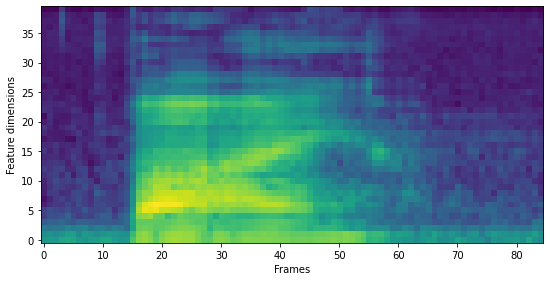

In [17]:
# Mel-scale spectrogram
mel_spec_y = librosa.feature.melspectrogram(
    y/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
    )
log_mel_spec_y = np.log(mel_spec_y)

# Plot log-Mel spectrogram
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(log_mel_spec_y, origin="lower", interpolation="nearest");
plt.ylabel("Feature dimensions")
plt.xlabel("Frames");

In [18]:
x_seq = log_mel_spec_x.T
y_seq = log_mel_spec_y.T

dist_mat = dist.cdist(x_seq, y_seq, "cosine")
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[-1, -1]))

Alignment cost: 0.5887


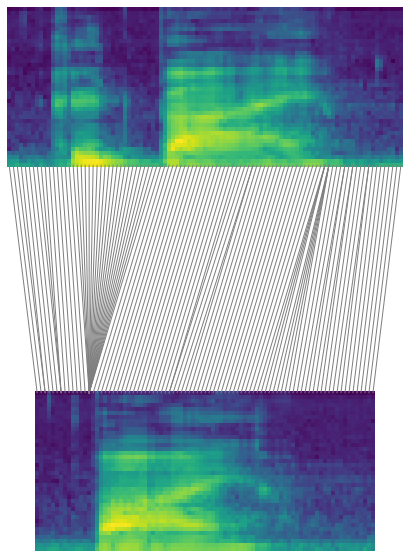

In [19]:
fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)

ax1.imshow(log_mel_spec_x, origin="lower", interpolation="nearest")
ax2.imshow(log_mel_spec_y, origin="lower", interpolation="nearest")
ax1.axis("off")
ax2.axis("off")

for x_i, y_j in path:
    con = ConnectionPatch(
        xyA=(x_i, 0), xyB=(y_j, log_mel_spec_y.shape[0] - 1), coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color="C7"
        )
    ax2.add_artist(con)

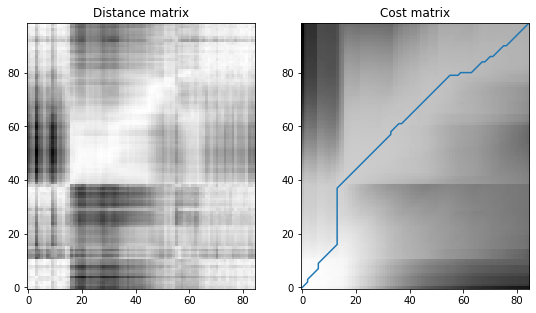

In [20]:
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);

### Nearest neighbour

In [21]:
# Audio
query_fn = "audio/hello1.wav"
f_s, x = wavfile.read(query_fn)

# Mel-scale spectrogram
mel_spec_x = librosa.feature.melspectrogram(
    x/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
    )
log_mel_spec_x = np.log(mel_spec_x)
x_seq = log_mel_spec_x.T

ipyd.Audio(rate=f_s, data=x)

In [22]:
audio_files = [
    "audio/hello2.wav", "audio/hello3.wav",
    "audio/bye.wav", "audio/cat.wav", "audio/goodbye.wav"
    ]
for neighbour_fn in audio_files:
    
    # Mel-scale spectrogram
    print("Reading:", neighbour_fn)
    f_s, y = wavfile.read(neighbour_fn)
    mel_spec_y = librosa.feature.melspectrogram(
        y/1.0, sr=f_s, n_mels=40,
        n_fft=n_fft, hop_length=hop_length
        )
    log_mel_spec_y = np.log(mel_spec_y)
    y_seq = log_mel_spec_y.T

    dist_mat = dist.cdist(x_seq, y_seq, "cosine")
    path, cost_mat = dp(dist_mat)
    print("Alignment cost: {:.4f}".format(cost_mat[-1, -1]))
    M = y_seq.shape[0]
    N = x_seq.shape[0]
    print(
        "Normalized alignment cost: {:.8f}".format(
        cost_mat[-1, -1]/(M + N))
        )
    print()

Reading: audio/hello2.wav
Alignment cost: 0.6059
Normalized alignment cost: 0.00317223

Reading: audio/hello3.wav
Alignment cost: 0.9529
Normalized alignment cost: 0.00427302

Reading: audio/bye.wav
Alignment cost: 0.6545
Normalized alignment cost: 0.00404026

Reading: audio/cat.wav
Alignment cost: 0.5685
Normalized alignment cost: 0.00477716

Reading: audio/goodbye.wav
Alignment cost: 0.8341
Normalized alignment cost: 0.00473900



In [23]:
# Audio
tmp_fn = "audio/cat.wav"
f_s, tmp = wavfile.read(tmp_fn)
ipyd.Audio(rate=f_s, data=tmp)